In [16]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm
 
from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints, files_to_datapoints_imagenet
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
"""
There exists 4 datasets. The main one is the uncommented bellow.
There also exists a dataset of MNIST recorded by a different headset, a dataset of generated data used to test the correctness of the pipeline.
The imagenet dataset was a last ditch effort to see if we could achieve better results from that. Could not :(

Also, interpolated clean data contains data that has had channels with a corrlation below 0.1 repaired with spherical spline interpolation.
"""

#files = glob.glob('./Datasets/MindBigData-EP-v1.0/*.csv')
files = glob.glob('./Datasets/Interpolated_Clean_Data2/*.csv')
#files = glob.glob('./Datasets/GeneratedData/*.csv')
#files = glob.glob('./Datasets/MindBigData-Imagenet-IN/MindBigData-Imagenet/*.csv')
#all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files), return_nulls=False) #first_n = 500 by default.
all_points, all_labels = files_to_datapoints(files, first_n=len(files), ignore=[])

Loading epoc data...


100%|██████████| 21965/21965 [00:27<00:00, 796.62it/s]


In [18]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 21965
Num labels EPOC: 10
Labels EPOC: ['4', '7', '0', '9', '1', '3', '2', '5', '6', '8']
------------------------------------
Data shape EPOC (4, 256)


Only run if loading the raw data

In [19]:
"""
1. Baseline average reference
2. Crop to channels
3. Highpass/Lowpass filter
"""
"""for point in tqdm(all_points):
    point.full_clean()"""

'for point in tqdm(all_points):\n    point.full_clean()'

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss 
from models.EegClassifierA import Classifier, ClassifierB, ClassifierWWW, ClassifierNoPool
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from EegHelper.EegAugmentation import *

%matplotlib inline

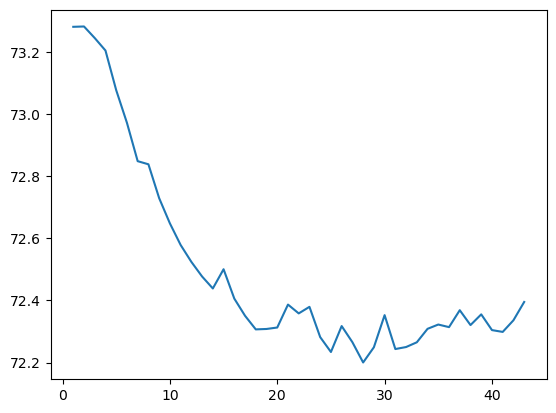

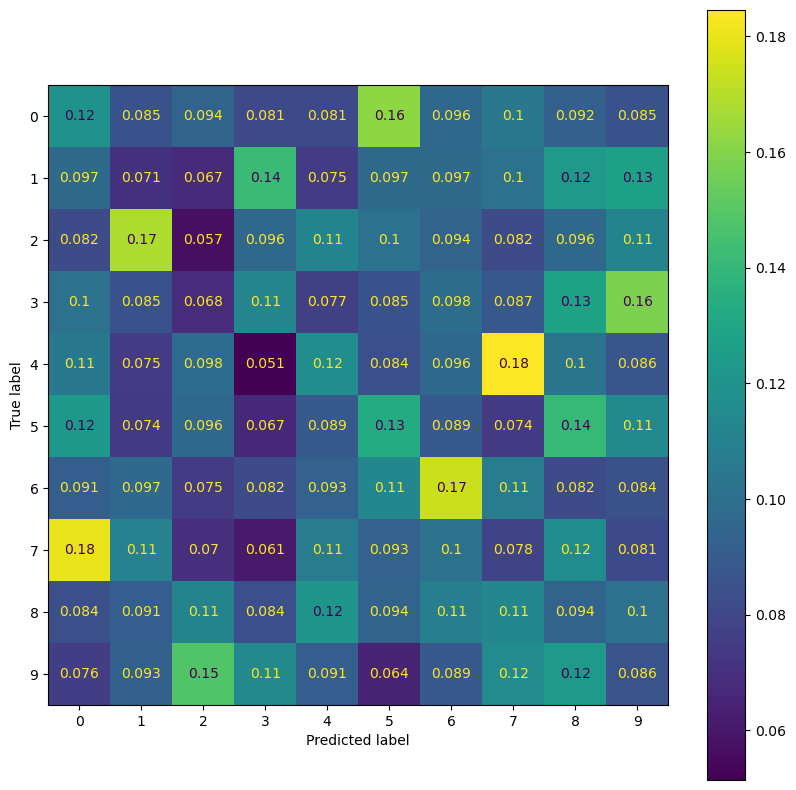

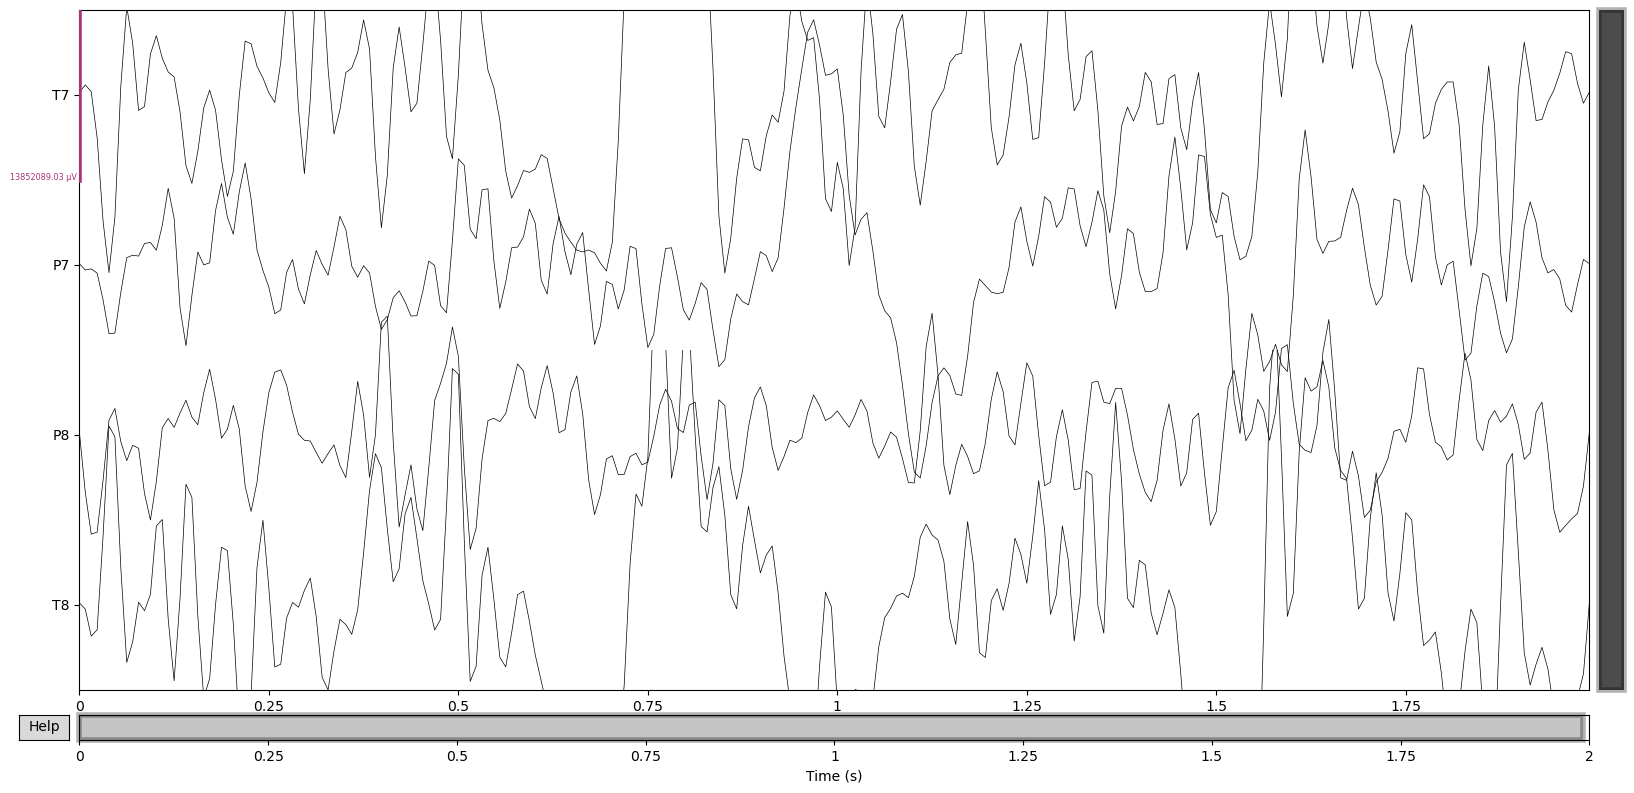

In [21]:
all_points[0].mne_object.plot(scalings='auto');

In [22]:
seed = 123
train_points, test_points = train_test_split(all_points, train_size=0.8, shuffle=True, random_state=seed)

"""helper = NormalizationHelper(train_points)           #Provide the data which you want to fit with
scaler = helper.get_robust_scaler()                  #Get the fit scaler

train_points = NormalizationHelper.fit_points(scaler, train_points) #Fit points after providing scaler
test_points = NormalizationHelper.fit_points(scaler, test_points) #Fit points after providing scaler"""

'helper = NormalizationHelper(train_points)           #Provide the data which you want to fit with\nscaler = helper.get_robust_scaler()                  #Get the fit scaler\n\ntrain_points = NormalizationHelper.fit_points(scaler, train_points) #Fit points after providing scaler\ntest_points = NormalizationHelper.fit_points(scaler, test_points) #Fit points after providing scaler'

In [23]:
transforms = nn.Sequential(
    EegGaussianNoise(mu = 0, sigma = 0.2),
    #TimeDomainFlip(prob=0.3),
    #EegRandomScaling(mu=1, sigma=0.1),
    #TimeCut(0.5, sigma = 0.5),
    #InvertFrequencies(0.5),
    EegSmoothZeroMask(20, 0.2),
)

batch_size = 32
num_workers = 1

dataset_train = EegDataset(data_points=train_points, labels=all_labels, transforms = transforms)
dataset_test = EegDataset(data_points=test_points, labels=all_labels)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 

dropout_p = 0.5
lr = 0.0001
description = "smooth mask and gaussian noise"
title = f"Dropout p: {dropout_p}. Learning rate: {lr}. Batch size: {batch_size}. {description}"

model = Classifier(dropout_p=dropout_p, num_classes=10).to(device=device)

optimizer = Adam(model.parameters(), lr=lr)                                           
loss_function = CrossEntropyLoss()

n_epochs = 50

validation_data = []
training_data = []

last_val = 0
last_train = 0

best_val_loss = 1000
best_val_accuracy = 0

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*data.size(0)

        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==expected_prediction))        
        
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)
    print("Change in train loss: ", train_loss.item() - last_train)
    last_train = train_loss.item()
    print("------------------Validating--------------------")
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy+=int(torch.sum(prediction==expected_prediction))        
        #Loss
        val_loss += loss_function(outputs, labels)*data.size(0)

    val_loss /= len(test_dataloader)
    
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)
    print("Change in val loss: ", val_loss.item() - last_val)
    last_val = val_loss.item()
    best_val_accuracy = max(best_val_accuracy, val_accuracy)
    if(last_val < best_val_loss):
        best_val_loss = last_val
        model.save(path='./models/saved/best_deepclean.pt')
    print("-------------------------------------- ---------")

cpu
Epoch 1/50


100%|██████████| 550/550 [00:03<00:00, 149.30it/s]

Epoch train loss: 73.57080078125
Epoch accuracy: 0.103125
Change in train loss:  73.57080078125
------------------Validating--------------------


Validation loss: 73.29496002197266
Validation accuracy: 0.09895833333333333
Change in val loss:  73.29496002197266
-------------------------------------- ---------
Epoch 2/50


100%|██████████| 550/550 [00:03<00:00, 158.92it/s]

Epoch train loss: 73.51895141601562
Epoch accuracy: 0.10823863636363637
Change in train loss:  -0.051849365234375
------------------Validating--------------------


Validation loss: 73.2883071899414
Validation accuracy: 0.1082427536231884
Change in val loss:  -0.00665283203125
-------------------------------------- ---------
Epoch 3/50


100%|██████████| 550/550 [00:03<00:00, 151.72it/s]

Epoch train loss: 73.48309326171875
Epoch accuracy: 0.110625
Change in train loss:  -0.035858154296875
------------------Validating--------------------


Validation loss: 73.25985717773438
Validation accuracy: 0.11571557971014493
Change in val loss:  -0.02845001220703125
-------------------------------------- ---------
Epoch 4/50


100%|██████████| 550/550 [00:03<00:00, 156.10it/s]

Epoch train loss: 73.3989028930664
Epoch accuracy: 0.11630681818181818
Change in train loss:  -0.08419036865234375
------------------Validating--------------------


Validation loss: 73.19615173339844
Validation accuracy: 0.12567934782608695
Change in val loss:  -0.0637054443359375
-------------------------------------- ---------
Epoch 5/50


100%|██████████| 550/550 [00:03<00:00, 149.36it/s]

Epoch train loss: 73.3031005859375
Epoch accuracy: 0.12926136363636365
Change in train loss:  -0.09580230712890625
------------------Validating--------------------


Validation loss: 73.06976318359375
Validation accuracy: 0.13111413043478262
Change in val loss:  -0.1263885498046875
-------------------------------------- ---------
Epoch 6/50


100%|██████████| 550/550 [00:03<00:00, 149.95it/s]

Epoch train loss: 73.09217834472656
Epoch accuracy: 0.14170454545454544
Change in train loss:  -0.2109222412109375
------------------Validating--------------------


Validation loss: 72.97178649902344
Validation accuracy: 0.1331521739130435
Change in val loss:  -0.0979766845703125
-------------------------------------- ---------
Epoch 7/50


100%|██████████| 550/550 [00:03<00:00, 157.57it/s]

Epoch train loss: 72.98641204833984
Epoch accuracy: 0.14460227272727272
Change in train loss:  -0.10576629638671875
------------------Validating--------------------


Validation loss: 72.83280181884766
Validation accuracy: 0.1503623188405797
Change in val loss:  -0.13898468017578125
-------------------------------------- ---------
Epoch 8/50


100%|██████████| 550/550 [00:03<00:00, 156.02it/s]


Epoch train loss: 72.86280822753906
Epoch accuracy: 0.15301136363636364
Change in train loss:  -0.12360382080078125
------------------Validating--------------------
Validation loss: 72.88236236572266
Validation accuracy: 0.13541666666666666
Change in val loss:  0.049560546875
-------------------------------------- ---------
Epoch 9/50


100%|██████████| 550/550 [00:03<00:00, 150.51it/s]

Epoch train loss: 72.6930160522461
Epoch accuracy: 0.15954545454545455
Change in train loss:  -0.16979217529296875
------------------Validating--------------------


Validation loss: 72.74507904052734
Validation accuracy: 0.14696557971014493
Change in val loss:  -0.1372833251953125
-------------------------------------- ---------
Epoch 10/50


100%|██████████| 550/550 [00:03<00:00, 157.61it/s]

Epoch train loss: 72.60758972167969
Epoch accuracy: 0.16471590909090908
Change in train loss:  -0.08542633056640625
------------------Validating--------------------


Validation loss: 72.7032470703125
Validation accuracy: 0.14741847826086957
Change in val loss:  -0.04183197021484375
-------------------------------------- ---------
Epoch 11/50


100%|██████████| 550/550 [00:03<00:00, 159.72it/s]

Epoch train loss: 72.62513732910156
Epoch accuracy: 0.16482954545454545
Change in train loss:  0.017547607421875
------------------Validating--------------------


Validation loss: 72.67277526855469
Validation accuracy: 0.1503623188405797
Change in val loss:  -0.0304718017578125
-------------------------------------- ---------
Epoch 12/50


100%|██████████| 550/550 [00:03<00:00, 155.00it/s]

Epoch train loss: 72.53886413574219
Epoch accuracy: 0.1684090909090909
Change in train loss:  -0.086273193359375
------------------Validating--------------------


Validation loss: 72.5792465209961
Validation accuracy: 0.15172101449275363
Change in val loss:  -0.09352874755859375
-------------------------------------- ---------
Epoch 13/50


100%|██████████| 550/550 [00:03<00:00, 157.19it/s]

Epoch train loss: 72.50786590576172
Epoch accuracy: 0.16914772727272728
Change in train loss:  -0.03099822998046875
------------------Validating--------------------


Validation loss: 72.57963562011719
Validation accuracy: 0.15058876811594202
Change in val loss:  0.00038909912109375
-------------------------------------- ---------
Epoch 14/50


100%|██████████| 550/550 [00:03<00:00, 159.43it/s]


Epoch train loss: 72.35517883300781
Epoch accuracy: 0.17778409090909092
Change in train loss:  -0.15268707275390625
------------------Validating--------------------
Validation loss: 72.5738525390625
Validation accuracy: 0.151268115942029
Change in val loss:  -0.0057830810546875
-------------------------------------- ---------
Epoch 15/50


100%|██████████| 550/550 [00:03<00:00, 156.13it/s]

Epoch train loss: 72.27596282958984
Epoch accuracy: 0.17880681818181818
Change in train loss:  -0.07921600341796875
------------------Validating--------------------


Validation loss: 72.5461654663086
Validation accuracy: 0.15738224637681159
Change in val loss:  -0.02768707275390625
-------------------------------------- ---------
Epoch 16/50


100%|██████████| 550/550 [00:03<00:00, 146.56it/s]

Epoch train loss: 72.34188079833984
Epoch accuracy: 0.17357954545454546
Change in train loss:  0.06591796875
------------------Validating--------------------


Validation loss: 72.57418823242188
Validation accuracy: 0.15217391304347827
Change in val loss:  0.02802276611328125
-------------------------------------- ---------
Epoch 17/50


100%|██████████| 550/550 [00:03<00:00, 154.24it/s]


Epoch train loss: 72.22367095947266
Epoch accuracy: 0.18017045454545455
Change in train loss:  -0.1182098388671875
------------------Validating--------------------
Validation loss: 72.52659606933594
Validation accuracy: 0.15511775362318841
Change in val loss:  -0.0475921630859375
-------------------------------------- ---------
Epoch 18/50


100%|██████████| 550/550 [00:03<00:00, 151.88it/s]

Epoch train loss: 72.18965148925781
Epoch accuracy: 0.18267045454545455
Change in train loss:  -0.03401947021484375
------------------Validating--------------------


Validation loss: 72.5391616821289
Validation accuracy: 0.15942028985507245
Change in val loss:  0.01256561279296875
-------------------------------------- ---------
Epoch 19/50


100%|██████████| 550/550 [00:03<00:00, 162.37it/s]

Epoch train loss: 72.09288787841797
Epoch accuracy: 0.18710227272727273
Change in train loss:  -0.09676361083984375
------------------Validating--------------------


Validation loss: 72.53006744384766
Validation accuracy: 0.15579710144927536
Change in val loss:  -0.00909423828125
-------------------------------------- ---------
Epoch 20/50


100%|██████████| 550/550 [00:03<00:00, 155.93it/s]

Epoch train loss: 72.03582763671875
Epoch accuracy: 0.18960227272727273
Change in train loss:  -0.05706024169921875
------------------Validating--------------------


Validation loss: 72.4968032836914
Validation accuracy: 0.1564764492753623
Change in val loss:  -0.03326416015625
-------------------------------------- ---------
Epoch 21/50


100%|██████████| 550/550 [00:03<00:00, 157.95it/s]

Epoch train loss: 72.0228271484375
Epoch accuracy: 0.1884659090909091
Change in train loss:  -0.01300048828125
------------------Validating--------------------


Validation loss: 72.4998779296875
Validation accuracy: 0.15964673913043478
Change in val loss:  0.00307464599609375
-------------------------------------- ---------
Epoch 22/50


100%|██████████| 550/550 [00:03<00:00, 150.99it/s]

Epoch train loss: 71.94164276123047
Epoch accuracy: 0.19471590909090908
Change in train loss:  -0.08118438720703125
------------------Validating--------------------


Validation loss: 72.4642562866211
Validation accuracy: 0.15783514492753623
Change in val loss:  -0.03562164306640625
-------------------------------------- ---------
Epoch 23/50


100%|██████████| 550/550 [00:03<00:00, 158.10it/s]

Epoch train loss: 71.85065460205078
Epoch accuracy: 0.19863636363636364
Change in train loss:  -0.0909881591796875
------------------Validating--------------------


Validation loss: 72.4825439453125
Validation accuracy: 0.15557065217391305
Change in val loss:  0.01828765869140625
-------------------------------------- ---------
Epoch 24/50


100%|██████████| 550/550 [00:03<00:00, 160.40it/s]

Epoch train loss: 71.90573120117188
Epoch accuracy: 0.19164772727272728
Change in train loss:  0.05507659912109375
------------------Validating--------------------


Validation loss: 72.46904754638672
Validation accuracy: 0.15806159420289856
Change in val loss:  -0.01349639892578125
-------------------------------------- ---------
Epoch 25/50


100%|██████████| 550/550 [00:03<00:00, 161.21it/s]

Epoch train loss: 71.95047760009766
Epoch accuracy: 0.1922159090909091
Change in train loss:  0.04474639892578125
------------------Validating--------------------


Validation loss: 72.45282745361328
Validation accuracy: 0.15421195652173914
Change in val loss:  -0.0162200927734375
-------------------------------------- ---------
Epoch 26/50


100%|██████████| 550/550 [00:03<00:00, 163.15it/s]

Epoch train loss: 71.93177795410156
Epoch accuracy: 0.19198863636363636
Change in train loss:  -0.01869964599609375
------------------Validating--------------------


Validation loss: 72.50099182128906
Validation accuracy: 0.15806159420289856
Change in val loss:  0.04816436767578125
-------------------------------------- ---------
Epoch 27/50


100%|██████████| 550/550 [00:03<00:00, 157.77it/s]

Epoch train loss: 71.8006591796875
Epoch accuracy: 0.19823863636363637
Change in train loss:  -0.1311187744140625
------------------Validating--------------------


Validation loss: 72.44410705566406
Validation accuracy: 0.1598731884057971
Change in val loss:  -0.056884765625
-------------------------------------- ---------
Epoch 28/50


100%|██████████| 550/550 [00:03<00:00, 161.35it/s]

Epoch train loss: 71.79679870605469
Epoch accuracy: 0.19789772727272728
Change in train loss:  -0.0038604736328125
------------------Validating--------------------


Validation loss: 72.43914031982422
Validation accuracy: 0.15919384057971014
Change in val loss:  -0.00496673583984375
-------------------------------------- ---------
Epoch 29/50


100%|██████████| 550/550 [00:03<00:00, 155.79it/s]

Epoch train loss: 71.65363311767578
Epoch accuracy: 0.2059659090909091
Change in train loss:  -0.14316558837890625
------------------Validating--------------------


Validation loss: 72.4757308959961
Validation accuracy: 0.16191123188405798
Change in val loss:  0.036590576171875
-------------------------------------- ---------
Epoch 30/50


100%|██████████| 550/550 [00:03<00:00, 156.68it/s]

Epoch train loss: 71.70173645019531
Epoch accuracy: 0.20022727272727273
Change in train loss:  0.04810333251953125
------------------Validating--------------------


Validation loss: 72.46025085449219
Validation accuracy: 0.15896739130434784
Change in val loss:  -0.01548004150390625
-------------------------------------- ---------
Epoch 31/50


100%|██████████| 550/550 [00:03<00:00, 151.13it/s]

Epoch train loss: 71.60057830810547
Epoch accuracy: 0.20528409090909092
Change in train loss:  -0.10115814208984375
------------------Validating--------------------


Validation loss: 72.46495056152344
Validation accuracy: 0.15783514492753623
Change in val loss:  0.00469970703125
-------------------------------------- ---------
Epoch 32/50


100%|██████████| 550/550 [00:03<00:00, 163.55it/s]

Epoch train loss: 71.64375305175781
Epoch accuracy: 0.20221590909090909
Change in train loss:  0.04317474365234375
------------------Validating--------------------


Validation loss: 72.4794921875
Validation accuracy: 0.16259057971014493
Change in val loss:  0.0145416259765625
-------------------------------------- ---------
Epoch 33/50


100%|██████████| 550/550 [00:03<00:00, 148.52it/s]

Epoch train loss: 71.56488800048828
Epoch accuracy: 0.20545454545454545
Change in train loss:  -0.07886505126953125
------------------Validating--------------------


Validation loss: 72.47635650634766
Validation accuracy: 0.16145833333333334
Change in val loss:  -0.00313568115234375
-------------------------------------- ---------
Epoch 34/50


100%|██████████| 550/550 [00:03<00:00, 163.98it/s]

Epoch train loss: 71.6373519897461
Epoch accuracy: 0.20392045454545454
Change in train loss:  0.0724639892578125
------------------Validating--------------------


Validation loss: 72.48908996582031
Validation accuracy: 0.16145833333333334
Change in val loss:  0.01273345947265625
-------------------------------------- ---------
Epoch 35/50


100%|██████████| 550/550 [00:03<00:00, 165.29it/s]


Epoch train loss: 71.5220947265625
Epoch accuracy: 0.208125
Change in train loss:  -0.11525726318359375
------------------Validating--------------------
Validation loss: 72.46443176269531
Validation accuracy: 0.16259057971014493
Change in val loss:  -0.024658203125
-------------------------------------- ---------
Epoch 36/50


100%|██████████| 550/550 [00:03<00:00, 157.05it/s]

Epoch train loss: 71.5423812866211
Epoch accuracy: 0.20698863636363637
Change in train loss:  0.02028656005859375
------------------Validating--------------------


Validation loss: 72.48019409179688
Validation accuracy: 0.16417572463768115
Change in val loss:  0.0157623291015625
-------------------------------------- ---------
Epoch 37/50


100%|██████████| 550/550 [00:03<00:00, 154.00it/s]


Epoch train loss: 71.43931579589844
Epoch accuracy: 0.21113636363636365
Change in train loss:  -0.10306549072265625
------------------Validating--------------------
Validation loss: 72.4951400756836
Validation accuracy: 0.1610054347826087
Change in val loss:  0.01494598388671875
-------------------------------------- ---------
Epoch 38/50


100%|██████████| 550/550 [00:03<00:00, 148.40it/s]

Epoch train loss: 71.48117065429688
Epoch accuracy: 0.20738636363636365
Change in train loss:  0.0418548583984375
------------------Validating--------------------


Validation loss: 72.48409271240234
Validation accuracy: 0.16508152173913043
Change in val loss:  -0.01104736328125
-------------------------------------- ---------
Epoch 39/50


100%|██████████| 550/550 [00:03<00:00, 150.91it/s]

Epoch train loss: 71.28157043457031
Epoch accuracy: 0.21625
Change in train loss:  -0.1996002197265625
------------------Validating--------------------


Validation loss: 72.47134399414062
Validation accuracy: 0.1634963768115942
Change in val loss:  -0.01274871826171875
-------------------------------------- ---------
Epoch 40/50


100%|██████████| 550/550 [00:03<00:00, 154.27it/s]

Epoch train loss: 71.3109130859375
Epoch accuracy: 0.2175
Change in train loss:  0.0293426513671875
------------------Validating--------------------


Validation loss: 72.45661163330078
Validation accuracy: 0.16168478260869565
Change in val loss:  -0.01473236083984375
-------------------------------------- ---------
Epoch 41/50


100%|██████████| 550/550 [00:03<00:00, 156.80it/s]


Epoch train loss: 71.27069091796875
Epoch accuracy: 0.21545454545454545
Change in train loss:  -0.04022216796875
------------------Validating--------------------
Validation loss: 72.5201187133789
Validation accuracy: 0.1560235507246377
Change in val loss:  0.063507080078125
-------------------------------------- ---------
Epoch 42/50


100%|██████████| 550/550 [00:03<00:00, 157.80it/s]

Epoch train loss: 71.3597183227539
Epoch accuracy: 0.21414772727272727
Change in train loss:  0.08902740478515625
------------------Validating--------------------


Validation loss: 72.52094268798828
Validation accuracy: 0.15806159420289856
Change in val loss:  0.000823974609375
-------------------------------------- ---------
Epoch 43/50


100%|██████████| 550/550 [00:03<00:00, 167.25it/s]


Epoch train loss: 71.24543762207031
Epoch accuracy: 0.2203409090909091
Change in train loss:  -0.11428070068359375
------------------Validating--------------------
Validation loss: 72.4552001953125
Validation accuracy: 0.1621376811594203
Change in val loss:  -0.06574249267578125
-------------------------------------- ---------
Epoch 44/50


100%|██████████| 550/550 [00:03<00:00, 160.39it/s]

Epoch train loss: 71.23715209960938
Epoch accuracy: 0.21755681818181818
Change in train loss:  -0.0082855224609375
------------------Validating--------------------


Validation loss: 72.44379425048828
Validation accuracy: 0.15942028985507245
Change in val loss:  -0.01140594482421875
-------------------------------------- ---------
Epoch 45/50


100%|██████████| 550/550 [00:03<00:00, 161.76it/s]

Epoch train loss: 71.25688934326172
Epoch accuracy: 0.21761363636363637
Change in train loss:  0.01973724365234375
------------------Validating--------------------


Validation loss: 72.4828109741211
Validation accuracy: 0.16191123188405798
Change in val loss:  0.0390167236328125
-------------------------------------- ---------
Epoch 46/50


100%|██████████| 550/550 [00:03<00:00, 160.07it/s]

Epoch train loss: 71.12122344970703
Epoch accuracy: 0.22164772727272727
Change in train loss:  -0.1356658935546875
------------------Validating--------------------


Validation loss: 72.4587173461914
Validation accuracy: 0.1637228260869565
Change in val loss:  -0.0240936279296875
-------------------------------------- ---------
Epoch 47/50


100%|██████████| 550/550 [00:03<00:00, 162.01it/s]

Epoch train loss: 71.14537811279297
Epoch accuracy: 0.2230681818181818
Change in train loss:  0.0241546630859375
------------------Validating--------------------


Validation loss: 72.42106628417969
Validation accuracy: 0.166893115942029
Change in val loss:  -0.03765106201171875
-------------------------------------- ---------
Epoch 48/50


100%|██████████| 550/550 [00:03<00:00, 153.06it/s]

Epoch train loss: 71.03447723388672
Epoch accuracy: 0.22477272727272726
Change in train loss:  -0.11090087890625
------------------Validating--------------------


Validation loss: 72.44515228271484
Validation accuracy: 0.1644021739130435
Change in val loss:  0.02408599853515625
-------------------------------------- ---------
Epoch 49/50


100%|██████████| 550/550 [00:03<00:00, 159.70it/s]


Epoch train loss: 70.99539947509766
Epoch accuracy: 0.22732954545454545
Change in train loss:  -0.0390777587890625
------------------Validating--------------------
Validation loss: 72.45620727539062
Validation accuracy: 0.1634963768115942
Change in val loss:  0.01105499267578125
-------------------------------------- ---------
Epoch 50/50


100%|██████████| 550/550 [00:03<00:00, 161.78it/s]

Epoch train loss: 71.04891967773438
Epoch accuracy: 0.22426136363636365
Change in train loss:  0.05352020263671875
------------------Validating--------------------


Validation loss: 72.45772552490234
Validation accuracy: 0.15760869565217392
Change in val loss:  0.00151824951171875
-------------------------------------- ---------


In [26]:
print(best_val_loss)
print(best_val_accuracy)

72.42106628417969
0.166893115942029


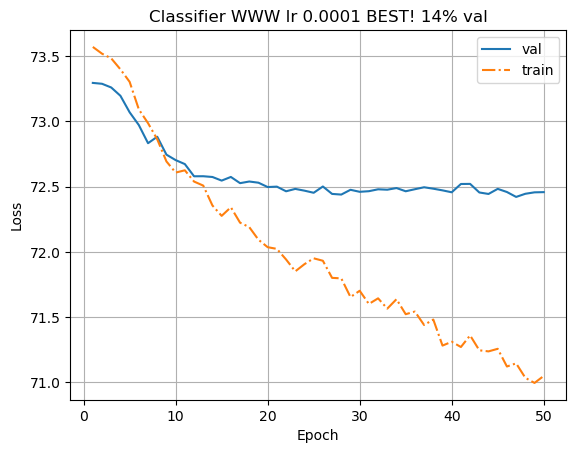

In [27]:
x = [i+1 for i in range(len(validation_data))]
title = 'Classifier WWW lr 0.0001 BEST! 14% val'

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(title)
plt.grid()

plt.show()

 
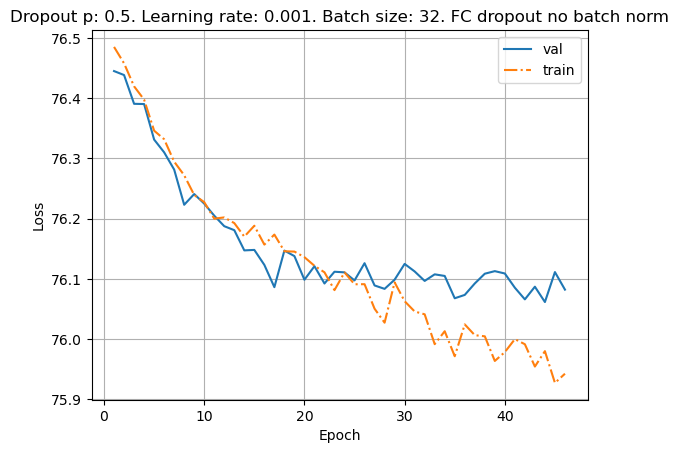   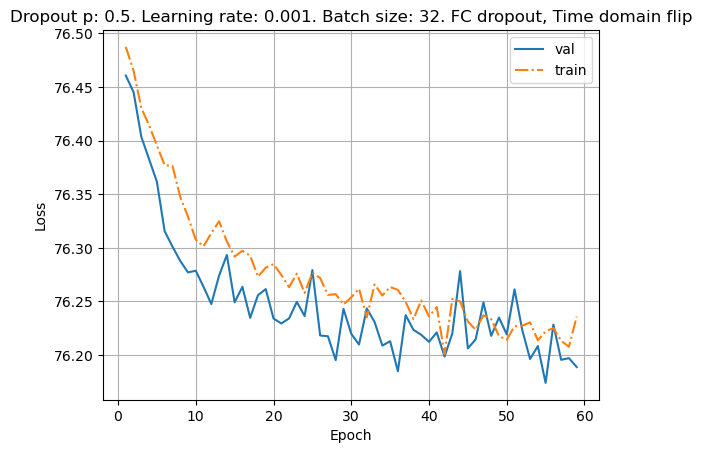   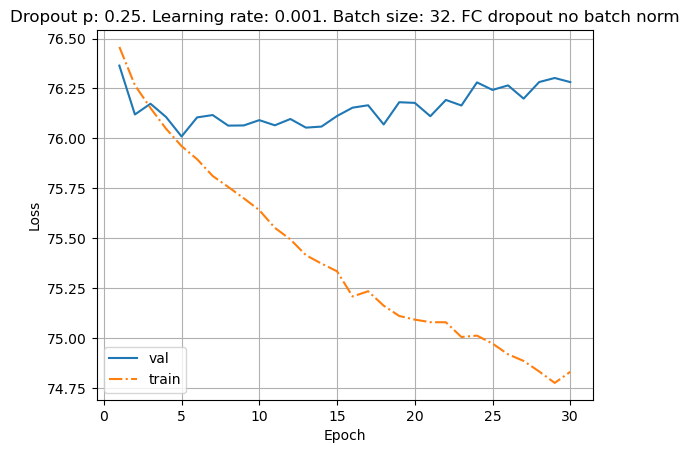 
  
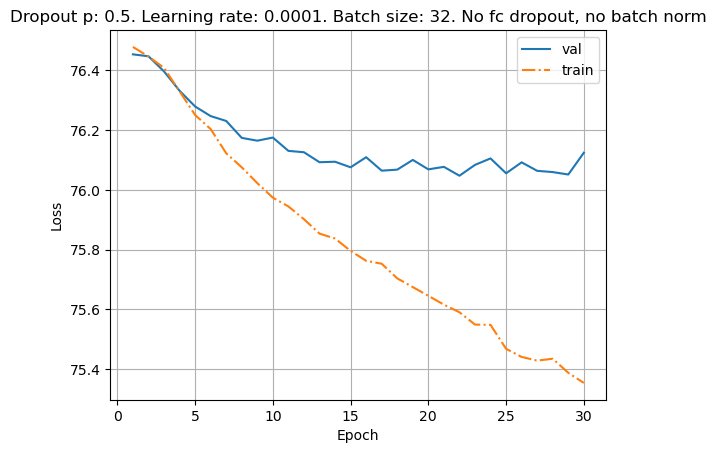  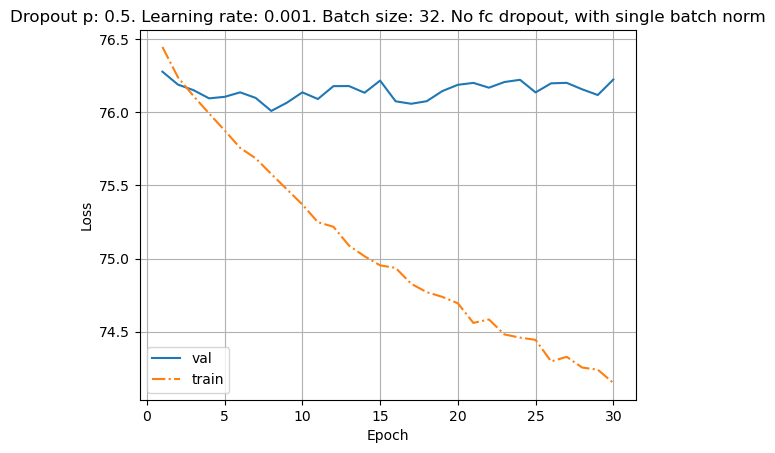    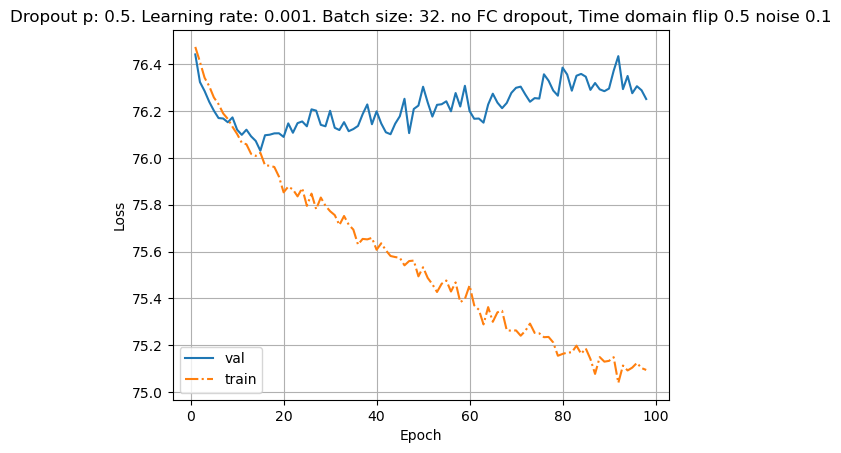  
![image.png] (attachment:image-9.png)
 
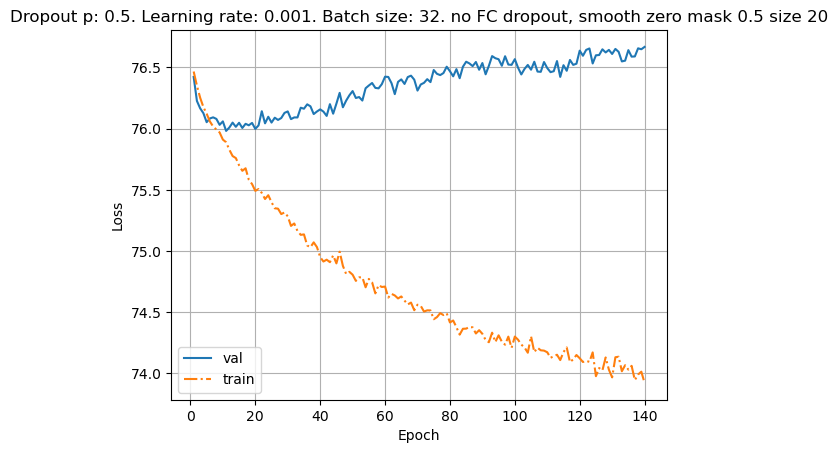     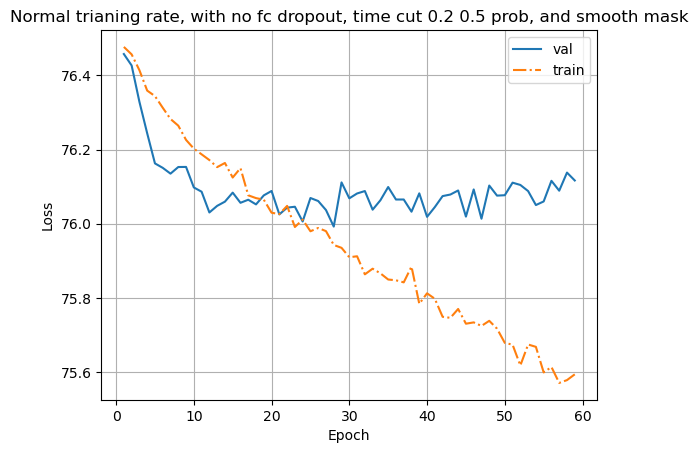    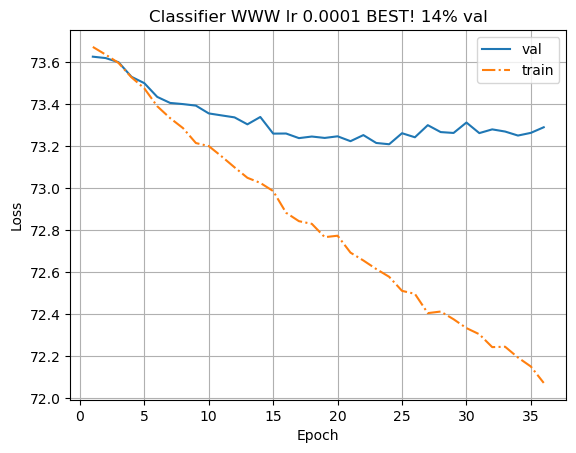

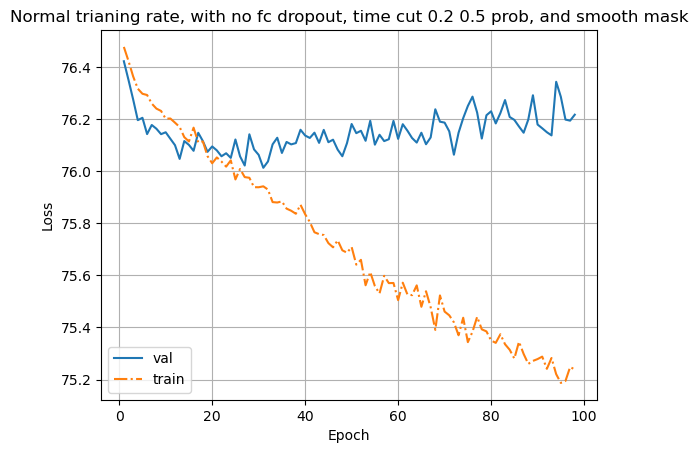   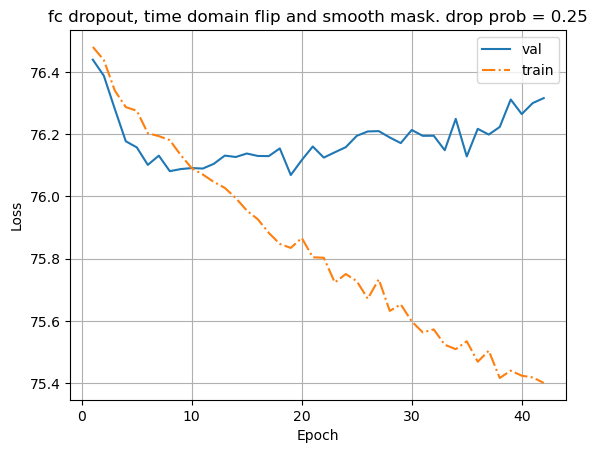

In [ ]:
"""
This is for the loading and inference of pretrained weights.
"""

In [28]:
from models.EegClassifierA import ClassifierWWW

model = Classifier(0.5, 10)
model.load_state_dict(torch.load('./models/saved/best_deepclean.pt'))
model.eval()

test_loss = 0.0
test_accuracy = 0.0
loss_function = CrossEntropyLoss()

y_true=[]
y_pred=[]

for data, labels in test_dataloader:
    outputs = model(data)
    #Prediction
    expected_prediction = []
    for idx, i in enumerate(labels):
        expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))

    expected_prediction = torch.Tensor(expected_prediction).type(torch.int16)
    _, prediction = torch.max(outputs.data, 1)
    test_accuracy+=int(torch.sum(prediction==expected_prediction)) 
    
    for i, pred in enumerate(expected_prediction):
        y_pred.append(pred.item())
        y_true.append(prediction[i].item())       
    #Loss
    test_loss += loss_function(outputs, labels)*data.size(0)

test_loss /= len(test_dataloader)
test_accuracy /= (len(test_dataloader)*batch_size)

In [29]:
print("Loss:", test_loss.item(), f"\n{test_accuracy * 100} %\n")
print(y_pred)
print(y_true)

Loss: 72.42106628417969 
16.6893115942029 %

[3, 7, 8, 1, 8, 8, 6, 9, 8, 8, 9, 8, 3, 4, 0, 1, 0, 6, 9, 5, 6, 5, 0, 2, 2, 1, 0, 9, 2, 1, 3, 2, 8, 9, 0, 4, 9, 2, 6, 9, 1, 7, 9, 5, 9, 5, 0, 0, 5, 5, 9, 9, 7, 0, 9, 4, 4, 8, 1, 9, 0, 4, 6, 4, 1, 6, 9, 2, 6, 7, 0, 9, 2, 4, 9, 4, 5, 2, 5, 8, 6, 1, 2, 0, 7, 0, 6, 5, 9, 0, 2, 4, 2, 2, 2, 5, 3, 0, 6, 0, 5, 9, 9, 8, 7, 0, 3, 1, 8, 5, 3, 8, 4, 3, 5, 4, 1, 0, 8, 4, 7, 7, 1, 4, 9, 1, 6, 7, 3, 1, 9, 2, 8, 1, 2, 3, 5, 0, 4, 2, 3, 1, 0, 8, 6, 7, 3, 1, 2, 5, 1, 1, 6, 3, 0, 5, 9, 8, 1, 7, 5, 0, 7, 9, 6, 2, 1, 5, 6, 3, 6, 5, 6, 8, 6, 9, 7, 1, 5, 5, 0, 9, 1, 4, 5, 1, 8, 8, 1, 7, 4, 1, 3, 1, 1, 6, 9, 9, 1, 0, 3, 5, 0, 3, 7, 9, 6, 5, 7, 1, 6, 8, 0, 9, 1, 4, 3, 0, 5, 6, 1, 4, 4, 8, 0, 0, 2, 3, 7, 8, 1, 2, 9, 4, 7, 7, 6, 2, 9, 7, 2, 8, 3, 8, 4, 2, 5, 5, 5, 2, 9, 5, 3, 7, 3, 4, 1, 1, 5, 8, 6, 9, 6, 9, 0, 4, 2, 0, 5, 0, 2, 4, 7, 9, 4, 9, 7, 0, 8, 6, 1, 5, 6, 9, 3, 5, 8, 4, 1, 5, 1, 2, 0, 6, 7, 9, 2, 2, 6, 7, 4, 8, 4, 4, 4, 6, 8, 6, 8, 0, 2, 7, 8, 6, 8, 6, 7, 8, 

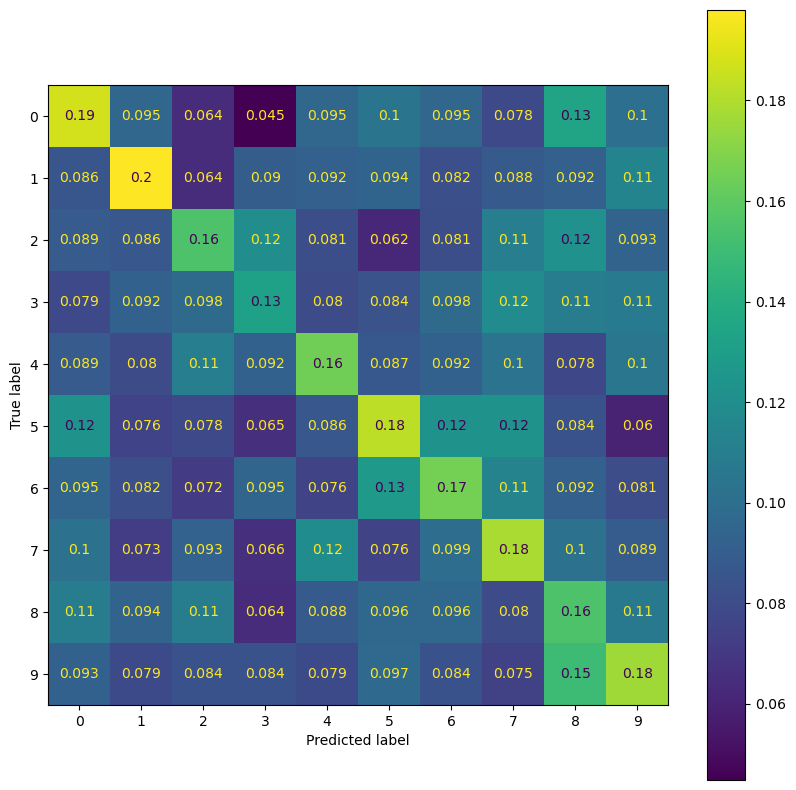

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=[i for i in range(10)], normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)